# Car Segmentation Task with U-NET Architecture

## Download dataset from Kaggle
Make sure to:
- Join competition on Kaggle
- Register API
- Export data from the zip folders

In [3]:
import kaggle
import os

kaggle.api.authenticate()

files = ["train.zip", "train_masks.zip"]

if len(os.listdir(".kaggle")) < len(files):
    # Download each file
    for file in files:
        kaggle.api.competition_download_file(competition="carvana-image-masking-challenge", file_name=file, path=".kaggle")

### Files that can be extracted

In [4]:
!kaggle competitions files -c carvana-image-masking-challenge

name                        size  creationDate         
-------------------------  -----  -------------------  
train.zip                  405MB  2018-06-22 02:52:10  
test.zip                     8GB  2018-06-22 02:52:10  
test_hq.zip                 15GB  2018-06-22 02:52:10  
train_hq.zip               804MB  2018-06-22 02:52:10  
metadata.csv.zip            81KB  2018-06-22 02:52:10  
train_masks.csv.zip         15MB  2018-06-22 02:52:10  
29bb3ece3180_11.jpg        107KB  2018-06-22 02:52:10  
sample_submission.csv.zip  202KB  2018-06-22 02:52:10  
train_masks.zip             29MB  2018-06-22 02:52:10  


## Import modules

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F

from torchvision import transforms
from torchvision.utils import save_image
import torchvision.transforms.functional as VT

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Define device used for training
device, pin_memory = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), torch.cuda.is_available()

# Root directory for dataset
dataroot = ".kaggle"

# Specify image dimensions
img_height = 160
img_width = 240

# Directories
image_dir = '.kaggle/train'
mask_dir = '.kaggle/train_masks'
model_output_folder = "model_outputs"

# Epochs to train for
num_epochs = 3

# Batch size for dataloading
batch_size = 16

# Pretrained model settings
use_pretrained = False
continue_training = True
checkpoint_path = "models\\model.pth"

# Percentage of data in the train set
train_split = 0.9

## Data Preparation

### Create Custom Dataset
This class handles transforming the requested image to fit the model

In [7]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.image_files[index])
        mask_path = os.path.join(self.mask_dir, self.mask_files[index])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            flip = False
            if np.random.random() > 0.5:
                flip = True
            image = self.transform(image)
            mask = self.transform(mask)
            mask = mask * (mask == 1.0)
            if flip:
                image = torch.flip(image, dims=[2])
                mask  = torch.flip(mask , dims=[2])

        return image, mask

### Define transform for data, datasets, and dataloaders

In [8]:
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

dataset = ImageDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)

train_size = int(len(dataset) * train_split)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)

### Test image transform to consist of only black ($0.0$) or white ($1.0$) pixels.

In [9]:
value_counts = {}

for x in train_dataset[0][1].flatten():
    if x.item() in value_counts:
        value_counts[x.item()] += 1
    else:
        value_counts[x.item()] = 1

assert len(value_counts) == 2, "Values of masks must equal 0.0 or 1.0"
value_counts

{0.0: 32245, 1.0: 6155}

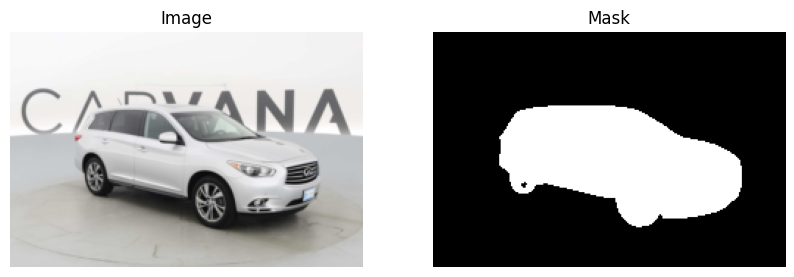

In [10]:
# Select a random sample
idx = np.random.randint(0, len(train_dataset))
image, mask = train_dataset[idx]

#image *= std.view(-1, 1, 1) + mean.view(-1, 1, 1)

#torch.clamp_(image, 0, 1)

# Convert tensors to NumPy format for plotting
image = image.permute(1, 2, 0).numpy()
mask = mask.permute(1, 2, 0).numpy()

# Plot side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image)
ax[0].set_title("Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap='gray') # Use grayscale colormap for mask
ax[1].set_title("Mask")
ax[1].axis("off")

plt.show()

## Create U-NET Model
![alt text](UNET_Architecture.jpg "UNET")

### Implementation in PyTorch

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)
    
class UNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()

        self.down = nn.ModuleList([])
        self.up = nn.ModuleList([])
        self.pool = nn.MaxPool2d(2, 2)

        for feature in features:
            self.down.append(ConvBlock(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.up.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.up.append(ConvBlock(feature * 2, feature))

        self.bottle_neck = ConvBlock(features[-1], features[-1] * 2)
        self.output = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for block in self.down:
            x = block(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottle_neck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.up), 2):
            x = self.up[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = VT.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.up[idx+1](concat_skip)

        return self.output(x)

### Loss function

In [12]:
def dice_loss(pred, target, smooth=1e-6):

    pred = torch.sigmoid(pred) # Ensure it's in the range [0,1]
    
    # Flatten tensors to (N, H*W) for easier computation
    pred = pred.view(pred.shape[0], -1)
    target = target.view(target.shape[0], -1)

    # Compute intersection and union
    intersection = (pred * target).sum(dim=1)
    union = (pred + target).sum(dim=1)

    # Compute Dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)
    
    # Return Dice loss (1 - Dice coefficient)
    return 1 - dice.mean()

def dice_bce_loss(pred, target, alpha=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    dice = dice_loss(pred, target)
    return alpha * bce + (1 - alpha) * dice

## Training

### Instantiate model, optimizer, and loss function

In [13]:
model = UNET(in_channels=3, out_channels=1, features=[64, 128, 256, 512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

if use_pretrained:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = dice_bce_loss

print("Number of parameters:", count_parameters(model))

Number of parameters: 31043521


### Train model

In [14]:
if continue_training:
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        loop = tqdm(train_loader, total=len(train_loader), desc=f"[{epoch+1}/{num_epochs}] loss=inf")
        for idx, (x_batch, y_batch) in enumerate(loop):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            logits = model(x_batch)
            logits = logits.squeeze(1)

            loss = loss_fn(logits, y_batch.squeeze(1))
            total_loss += loss.item()
            
            if (idx + 1) % 10 == 0:
                loop.desc = f"[{epoch+1}/{num_epochs}] loss={round(total_loss / (idx + 1), 5)}"

            loss.backward()
            optimizer.step()

        # Use to test a testing dataset
        """for idx, (x_batch, y_batch) in enumerate(test_dataloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            logits = model(x_batch)
            logits = logits.squeeze(1)

            loss = loss_fn(logits, y_batch.squeeze(1))
            total_loss += loss.item()
            
            if (idx + 1) % 10 == 0:
                loop.desc = f"[{epoch+1}/{num_epochs}] loss={round(total_loss / (idx + 1), 5)}"

            loss.backward()
            optimizer.step()"""

[3/3] loss=0.09139: 100%|██████████| 287/287 [02:57<00:00,  1.61it/s]


## Testing

### Output model predictions to "model_outputs"

In [15]:
model.eval()
for idx, (x, y) in enumerate(test_dataset):
    x: torch.Tensor
    y: torch.Tensor

    x = x.to(device=device).unsqueeze(0)
    with torch.no_grad():
        preds = model(x)
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()
    save_image(
        preds, f"{model_output_folder}\\{idx}_pred.png"
    )
    save_image(y.unsqueeze(1), f"{model_output_folder}\\{idx}_real.png")
    if idx + 1 == 50:
        break

### Calculate Dice Score

In [16]:
num_correct = 0
num_pixels = 0
dice_score = 0
model.eval()

with torch.no_grad():
    for x, y in tqdm(test_loader, total=len(test_loader)):
        x = x.to(device)
        y = y.to(device)
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()
        num_correct += (preds == y).sum()
        num_pixels += torch.numel(preds)
        dice_score += (2 * (preds * y).sum()) / (
            (preds + y).sum() + 1e-8
        )

print(
    f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
)
print(f"Dice score: {dice_score/len(test_loader)}")

100%|██████████| 32/32 [00:16<00:00,  1.89it/s]

Got 19446663/19545600 with acc 99.49
Dice score: 0.987259566783905


### Calculate Intersection over Under (IoU) score

In [17]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, smooth: float = 1e-6):
    outputs = (outputs > 0.5).float()  # Convert to boolean mask
    labels = (labels > 0.5).float()    # Convert to boolean mask
    
    intersection = (outputs * labels).sum() # Element-wise AND
    union = (outputs + labels).clamp(0, 1).sum() # Element-wise OR

    iou = intersection / (union + smooth)  # Smooth to avoid division by zero
    
    return iou  # Return IoU values

In [18]:
total_iou = 0

with torch.no_grad():
    for x, y in tqdm(test_dataset, total=len(test_dataset)):
        x: torch.Tensor = x.to(device)
        y: torch.Tensor = y.to(device)
        x.unsqueeze_(0)
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()
        preds.squeeze_(1)
        y.squeeze_(1)
        iou_score = iou_pytorch(preds, y)
        total_iou += iou_score

    print(f"IoU Score: {total_iou / len(test_dataset)}")

100%|██████████| 509/509 [00:18<00:00, 28.02it/s]

IoU Score: 0.9748151302337646


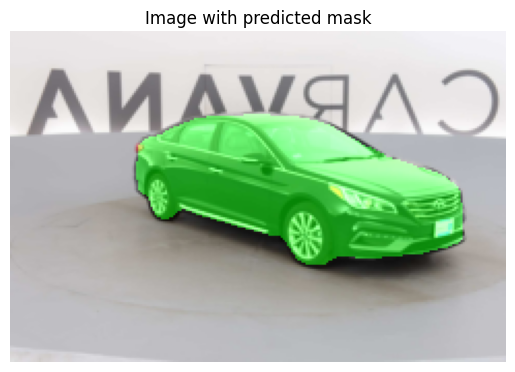

In [62]:
idx = np.random.randint(0, len(test_dataset))
test_image, _ = test_dataset[idx]

test_image: torch.Tensor
test_mask = F.sigmoid(model(test_image.unsqueeze(0).to(device))).squeeze(0).cpu().detach()
test_mask = (test_mask > 0.5).float()

test_mask = test_mask.expand_as(test_image)
green_tinted = test_image.clone()
green_tinted[1] = torch.clamp(green_tinted[1] + 0.5, 0, 1)

result = test_image * (1 - test_mask) + green_tinted * test_mask

result = result.permute(1, 2, 0).numpy()

plt.imshow(result)
plt.title("Image with predicted mask")
plt.axis('off')
plt.show()

### Save model

In [19]:
if continue_training:
    num_models = len(os.listdir('models'))
    model_path = f"models\\model_{num_models}.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, model_path)